In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight


In [7]:
# 1. Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
train_dir = '../../data5/train'
test_dir  = '../../data5/test'

# 2. Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   vertical_flip=True)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())
print("Classes:", class_labels)

# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
Classes: ['1. Enfeksiyonel', '2. Ekzama', '3. Akne', '4. Malign']


In [8]:
# 3. Load and Configure ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, 
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze first (all but last 50) layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 16,958,724 (64.69 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [9]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.6667 - loss: 0.8698 - val_accuracy: 0.7989 - val_loss: 0.5255 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.8633 - loss: 0.3661 - val_accuracy: 0.8210 - val_loss: 0.5013 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.9273 - loss: 0.2362 - val_accuracy: 0.8234 - val_loss: 0.5233 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.9439 - loss: 0.1647 - val_accuracy: 0.8230 - val_loss: 0.5800 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.9558 - loss: 0.1346 - val_accuracy: 0.8420 - val_loss: 0.5326 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.9649 - loss: 0.1053 - val_accuracy: 0.8385 - val_loss: 0.6657 - learning_rate: 1.0000e-04
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.97

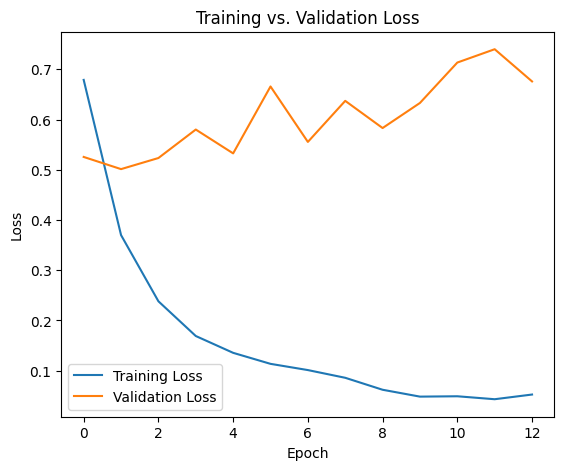

In [14]:
# 5. Plot Training vs. Validation Curves
plt.figure(figsize=(14, 5))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


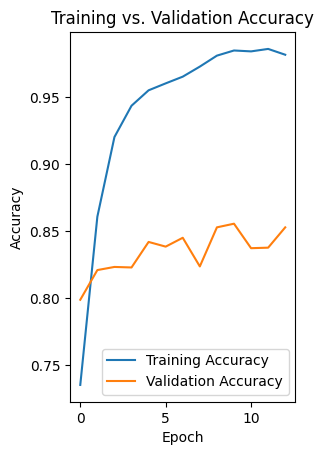

In [15]:
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


81/81 ━━━━━━━━━━━━━━━━━━━━ 80s 987ms/step - accuracy: 0.8059 - loss: 0.7916
Test Loss: 0.6329536437988281
Test Accuracy: 0.8555900454521179
81/81 ━━━━━━━━━━━━━━━━━━━━ 79s 968ms/step

Classification Report:
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.74      0.80      0.77       650
      2. Ekzama       0.83      0.80      0.82       650
        3. Akne       0.92      0.91      0.92       626
      4. Malign       0.96      0.90      0.93       650

       accuracy                           0.86      2576
      macro avg       0.86      0.86      0.86      2576
   weighted avg       0.86      0.86      0.86      2576

Confusion Matrix:
 [[522  86  26  16]
 [104 523  17   6]
 [ 40   9 572   5]
 [ 42  15   6 587]]
Macro-average ROC AUC: 0.966429445453773
Micro-average ROC AUC: 0.9705070414271568


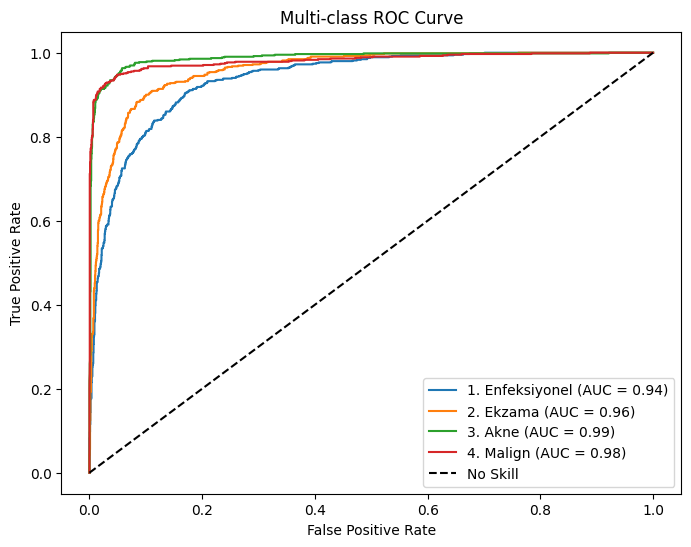

In [16]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# 7. Classification Report & Confusion Matrix
y_pred_probs = model.predict(test_generator)
y_pred_indices = np.argmax(y_pred_probs, axis=1)
y_true_indices = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true_indices, y_pred_indices, target_names=class_labels))

cm = confusion_matrix(y_true_indices, y_pred_indices)
print("Confusion Matrix:\n", cm)

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [13]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Val Loss:", test_loss)
print("Val Accuracy:", test_accuracy)

81/81 ━━━━━━━━━━━━━━━━━━━━ 78s 960ms/step - accuracy: 0.8059 - loss: 0.7916
Val Loss: 0.6329536437988281
Val Accuracy: 0.8555900454521179


In [18]:
# 6. Evaluate on Test Set
train_loss, train_accuracy = model.evaluate(train_generator)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

188/188 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9917 - loss: 0.0287
Train Loss: 0.029169058427214622
Train Accuracy: 0.9906651377677917
